In [2]:
!pip install yfinance tweepy nltk scikit-learn matplotlib

In [3]:
pip install treeinterpreter

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import tweepy
import nltk
import re
import string
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [5]:
# Setup NLTK and Sentiment Analyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
sentiment_i_a = SentimentIntensityAnalyzer()

# Twitter API keys (replace with yours)
consumer_key = "kQUlGRFpU6S1mY8XiGOVemlAZ"
consumer_secret = "15XrXxTMbehqCWqcOdyjvsDX4hnfYGQvPhFhswvCuRgRUQbaji"
access_token = "1865373336450301952-YizirWUaLz6vfdy7Zoujg3KRnHXoUB"
access_token_secret = "sPz5WePySU7HblOV0SrMxJcGVw0pAwJkhv7nilyTEO0zY"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### `getStockDetails` Function

This function fetches historical stock data from Yahoo Finance for a given stock symbol and date range. It performs the following:

- **Inputs**:
  - `stockname`: Stock ticker symbol (e.g., 'AAPL').
  - `start_time`: Start date (ISO format, e.g., '2023-01-01').
  - `end_time`: End date (ISO format, e.g., '2023-12-31').

- **Process**:
  - Sanitizes the date inputs.
  - Fetches stock data (Open, Close, High, Low, Volume) using `yfinance`.
  - Saves data to a CSV file (`stockData_{stockname}.csv`).
  - Plots the stock's closing price over time.

- **Output**:
  - Returns the stock data as a DataFrame.
  - Saves the data to a CSV and plots the closing price.

- **Error Handling**:
  - Displays an error message if stock data can't be fetched.



In [34]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

def getStockDetails(stockname, start_time, end_time):
    try:
        # Remove 'T00:00:00Z' part from the start_time and end_time
        start_time = start_time.split('T')[0]
        end_time = end_time.split('T')[0]

        # Fetch stock data from Yahoo Finance
        stock = yf.download(stockname, start=start_time, end=end_time)

        if stock.empty:
            print("No stock data found.")
            return stock

        # Convert the index (Date) into a column explicitly
        stock.reset_index(inplace=True)

        # Print the columns to ensure 'Date' is there
        print("Stock Data Columns:", stock.columns)

        # Save the stock data to a CSV file
        stock.to_csv(f"stockData_{stockname}.csv", index=False)

        # Check if 'Date' is present, and use it in plotting
        if 'Date' in stock.columns:
            print("Date column found.")
        else:
            print("No Date column found. Check your data.")

        # Plot the stock closing price
        plt.figure(figsize=(10, 6))
        plt.plot(stock['Date'], stock['Close'], label=f"{stockname} Closing Price", color="blue")
        plt.title(f"{stockname} Stock Price from {start_time} to {end_time}")
        plt.xlabel("Date")
        plt.ylabel("Closing Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()

        return stock

    except Exception as e:
        print(f"An error occurred while fetching stock data: {e}")



### `TweetCleaner` Class

This class cleans tweet text by performing the following operations:

- **Initialization**:
  - Loads English stop words using `nltk`.
  - Creates a punctuation translation table for text cleaning.

- **Methods**:
  - `remove_non_ascii_chars(text)`: Removes non-ASCII characters from the text.
  - `remove_hyperlinks(text)`: Removes any hyperlinks starting with "http".
  - `get_cleaned_text(text)`:
    - Removes unwanted characters (`\"`, `\'`, `-`).
    - Cleans non-ASCII characters and hyperlinks.
    - Tokenizes and lemmatizes the text.
    - Removes stop words and single-character tokens.
    - Returns the cleaned text as a space-separated string.

- **Usage**:
  - Used for preprocessing tweet text by cleaning and normalizing it for further analysis.



In [7]:
# Tweet Cleaner Class
class TweetCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation)

    def remove_non_ascii_chars(self, text):
        return ''.join([w if ord(w) < 128 else ' ' for w in text])

    def remove_hyperlinks(self, text):
        return ' '.join([w for w in text.split(' ') if not 'http' in w])

    def get_cleaned_text(self, text):
        cleaned_tweet = text.replace('\"', '').replace('\'', '').replace('-', ' ')
        cleaned_tweet = self.remove_non_ascii_chars(cleaned_tweet)
        cleaned_tweet = self.remove_hyperlinks(cleaned_tweet)
        tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_tweet)]
        tokens = [nltk.WordNetLemmatizer().lemmatize(w) for w in tokens if w.lower() not in self.stop_words and len(w) > 1]
        return ' '.join(tokens)

### `fetchTweets` Function

This function fetches the most recent tweets about a given stock symbol using the Twitter API:

- **Parameters**:
  - `stockname`: The stock symbol (e.g., "AAPL") for which to fetch tweets.
  - `max_results` (default 100): The maximum number of tweets to retrieve.

- **Process**:
  - Fetches tweets from the last 7 days based on the stock name.
  - Filters out retweets and collects tweet information such as `created_at`, `text`, and `like_count`.
  - Sorts the tweets by the number of likes in descending order.
  - Saves the tweet data in a CSV file named `tweets_<stockname>.csv`.

- **Error Handling**:
  - Handles Twitter rate limiting by waiting 15 minutes before retrying.
  - Handles general API exceptions and prints the error message.

- **Usage**:
  - Fetches tweets about a specific stock and saves them to a CSV for further analysis.



In [17]:
import tweepy
import csv
import time
from datetime import datetime, timedelta

# Twitter API authentication
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAGSmxQEAAAAAhYK56dqcILt3857%2BpJA%2FQbxA5%2Fs%3DffO4TP9A3xlQEqDoXIK9ChxIng1T53uSM95N5PjKR0jnxQxvD2"
client = tweepy.Client(bearer_token=BEARER_TOKEN)

def fetchTweets(stockname, max_results=100):
    try:
        # Fixed 7-day range
        end_time = datetime.utcnow()
        start_time = end_time - timedelta(days=7)
        start_time_str = start_time.isoformat("T") + "Z"
        end_time_str = end_time.isoformat("T") + "Z"

        query = f"{stockname} -is:retweet"
        filename = f"tweets_{stockname}.csv"  # Dynamic filename based on stock name

        response = client.search_recent_tweets(
            query=query,
            start_time=start_time_str,
            end_time=end_time_str,
            max_results=max_results,
            tweet_fields=["created_at", "text", "public_metrics"]
        )

        if not response.data:  # Check if there are no tweets
            print("No tweets found for the query.")
            return

        # Collect and sort tweets by likes
        tweet_data = []
        for tweet in response.data:
            tweet_data.append({
                'created_at': tweet.created_at,
                'text': tweet.text,
                'likes': tweet.public_metrics['like_count']
            })

        sorted_tweets = sorted(tweet_data, key=lambda x: x['likes'], reverse=True)

        # Write to file
        with open(filename, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerow(["created_at", "text", "likes"])
            for tweet in sorted_tweets:
                writer.writerow([tweet['created_at'], tweet['text'], tweet['likes']])

        print(f"Saved {len(sorted_tweets)} tweets about '{stockname}' to {filename}")

    except tweepy.TooManyRequests:
        print("Rate limit exceeded. Waiting for 15 minutes...")
        time.sleep(15 * 60)
        fetchTweets(stockname, max_results)

    except tweepy.TweepyException as e:
        print(f"An error occurred: {e}")


### `processTweets` Function

This function processes tweet and stock data to merge them based on tweet information:

- **Parameters**:
  - `stockname`: The stock symbol (e.g., "AAPL") used to fetch the corresponding tweet and stock data.

- **Process**:
  - Loads tweets from a CSV file (`tweets_<stockname>.csv`), extracts the tweet text and like count, and combines tweets by summing likes for each unique tweet.
  - Loads stock data from a CSV file (`stockData_<stockname>.csv`) and removes the `Date` column.
  - Merges the tweet and stock data on their index (no direct date dependency).
  - Renames the `Likes` column to `Prices` for consistency, and ensures the values are in integer format.

- **Error Handling**:
  - Handles missing files for both tweets and stock data with appropriate error messages.
  
- **Usage**:
  - Combines tweet and stock data, processes it, and saves the final output to a new CSV file (`processedTweets_<stockname>.csv`) for further analysis.



In [46]:
import pandas as pd
import numpy as np

def processTweets(stockname):
    try:
        # Load tweets file
        tweets_file = f'tweets_{stockname}.csv'
        df = pd.read_csv(tweets_file, encoding='utf-8')

        # Print the column names to verify structure
        print(f"Columns in tweets file: {df.columns.tolist()}")

        # Assuming the tweets file has these columns
        df['Tweets'] = df['text']  # 'text' contains tweet text
        df['Likes'] = df['likes']  # 'likes' contains the like count

        # If Date column causes issues, just drop it
        df.drop(columns=['created_at'], errors='ignore', inplace=True)

        # Print a sample of the dataframe
        print("Sample of tweets data:\n", df.head())

    except FileNotFoundError:
        print(f"File '{tweets_file}' not found. Ensure the tweets have been fetched first.")
        return

    # Combine tweets by date (this step can still work even without Date)
    combined_data = df.groupby('Tweets')['Likes'].apply(lambda x: x.sum()).reset_index()
    print(f"Combined data:\n{combined_data.head()}")

    try:
        # Load stock data
        stock_file = f'stockData_{stockname}.csv'
        stock_df = pd.read_csv(stock_file)

        # Print the columns of stock data to verify structure
        print(f"Columns in stock data file: {stock_df.columns.tolist()}")

        # Drop the 'Date' column if it exists in stock data
        stock_df.drop(columns=['Date'], errors='ignore', inplace=True)

        # Print the stock data after dropping 'Date' column
        print(f"Stock Data after dropping Date column:\n{stock_df.head()}")

    except FileNotFoundError:
        print(f"File '{stock_file}' not found. Ensure stock data is available.")
        return

    # Merge tweets with stock data (no Date column dependency now)
    merged_data = pd.merge(combined_data, stock_df, left_index=True, right_index=True, how='inner')

    # Print merged data to ensure it's correct
    print(f"Merged data:\n{merged_data.head()}")

    # Rename and clean up
    merged_data['Prices'] = merged_data['Likes'].astype(np.int64)

    # Save processed data
    output_file = f'processedTweets_{stockname}.csv'
    merged_data.to_csv(output_file, index=False)
    print(f"Processed tweets saved to {output_file}")


In [10]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


### `sentimentAnalysis` Function

This function performs sentiment analysis on processed tweets related to a specific stock:

- **Parameters**:
  - `stockname`: The stock symbol (e.g., "AAPL") used to fetch the corresponding processed tweet data.

- **Process**:
  - Reads the processed tweets data from a CSV file (`processedTweets_<stockname>.csv`).
  - Uses NLTK's `SentimentIntensityAnalyzer` to analyze the sentiment of each tweet, calculating the compound, positive, negative, and neutral scores.
  - Adds the sentiment scores as new columns to the data.
  - Saves the sentiment analysis results to a new CSV file (`sentimentAnalysis_<stockname>.csv`).

- **Sentiment Statistics**:
  - Calculates the percentage of positive, negative, and neutral tweets based on the compound score.
  - Displays a pie chart to visualize the sentiment distribution.
  - Prints the percentage of positive, negative, and neutral tweets.

- **Error Handling**:
  - Handles missing files with an appropriate error message if the processed tweet data is not available.



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentimentAnalysis(stockname):
    try:
        # Read the processed tweets file
        data = pd.read_csv(f'processedTweets_{stockname}.csv', encoding='utf-8')
    except FileNotFoundError:
        print(f"File 'processedTweets_{stockname}.csv' not found. Ensure tweets are processed first.")
        return

    # Initialize Sentiment Analyzer
    sentiment_analyzer = SentimentIntensityAnalyzer()

    # Function to calculate sentiment scores for a given tweet
    def calculate_sentiment(tweet):
        try:
            if pd.isna(tweet) or not isinstance(tweet, str):
                return {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}
            clean_tweet = unicodedata.normalize('NFKD', tweet)
            return sentiment_analyzer.polarity_scores(clean_tweet)
        except Exception as e:
            print(f"Error processing tweet: {e}")
            return {'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}

    # Apply sentiment analysis to each tweet
    sentiment_results = data['Tweets'].apply(calculate_sentiment)

    # Add sentiment scores as new columns
    data['Comp'] = sentiment_results.apply(lambda x: x['compound'])
    data['Negative'] = sentiment_results.apply(lambda x: x['neg'])
    data['Neutral'] = sentiment_results.apply(lambda x: x['neu'])
    data['Positive'] = sentiment_results.apply(lambda x: x['pos'])

    # Save the sentiment data to a new CSV file
    output_file = f"sentimentAnalysis_{stockname}.csv"
    data.to_csv(output_file, index=False)
    print(f"Sentiment analysis results saved to {output_file}")

    # Calculate sentiment statistics
    positive_count = (data['Comp'] > 0).sum()
    negative_count = (data['Comp'] < 0).sum()
    neutral_count = (data['Comp'] == 0).sum()

    total = len(data)
    pos_percentage = (positive_count / total) * 100
    neg_percentage = (negative_count / total) * 100
    neutral_percentage = (neutral_count / total) * 100

    # Plot sentiment distribution as a pie chart
    sentiment_values = [pos_percentage, neg_percentage, neutral_percentage]
    plt.figure(figsize=(8, 6))
    plt.pie(sentiment_values, labels=['Positive', 'Negative', 'Neutral'], autopct='%1.1f%%', startangle=140,
            colors=["#00FF00", "#FF0000", "#808080"])
    plt.title(f"Sentiment Analysis for {stockname}")
    plt.show()

    # Print sentiment percentages
    print(f"% of Positive Tweets: {pos_percentage:.2f}%")
    print(f"% of Negative Tweets: {neg_percentage:.2f}%")
    print(f"% of Neutral Tweets: {neutral_percentage:.2f}%")


### `RandomForestModel` Function

This function predicts stock prices using a Random Forest model based on sentiment analysis data:

- **Parameters**:
  - `stockname`: The stock symbol (e.g., "AAPL") for which sentiment analysis and price predictions will be made.

- **Process**:
  - Loads sentiment analysis data (`sentimentAnalysis_<stockname>.csv`).
  - Verifies that required columns (`Negative`, `Neutral`, `Positive`, `Prices`) are present in the data.
  - Drops rows with missing values in any of these columns.
  - Splits the data into training (80%) and testing (20%) sets.
  - Trains a Random Forest Regressor on sentiment features (`Negative`, `Neutral`, `Positive`) to predict stock prices.
  - Plots actual vs predicted stock prices for visualization.
  - Calculates and prints the Root Mean Squared Error (RMSE) to evaluate the model.

- **Error Handling**:
  - Handles missing or incorrect data files and missing columns with appropriate error messages.



In [20]:
# Method for stock price prediction using Random Forest model
def RandomForestModel(stockname):
    try:
        # Load sentiment analysis data
        df = pd.read_csv(f'sentimentAnalysis_{stockname}.csv', encoding='utf-8')
    except FileNotFoundError:
        print(f"File 'sentimentAnalysis_{stockname}.csv' not found. Please run sentiment analysis first.")
        return
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    # Check for required columns
    required_columns = ['Negative', 'Neutral', 'Positive', 'Prices']
    if not all(col in df.columns for col in required_columns):
        print("One or more required columns ('Negative', 'Neutral', 'Positive', 'Prices') are missing.")
        return

    # Drop rows with missing values in sentiment and price columns
    df = df.dropna(subset=required_columns)

    # Split data into training and testing sets (80% train, 20% test)
    train, test = train_test_split(df, shuffle=False, test_size=0.2)

    # Sentiment features and target prices
    sentiment_columns = ['Negative', 'Neutral', 'Positive']
    X_train = train[sentiment_columns].values
    X_test = test[sentiment_columns].values
    y_train = train['Prices'].values
    y_test = test['Prices'].values

    # Train the Random Forest Regressor
    try:
        rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Tunable parameter: n_estimators
        rf.fit(X_train, y_train)
    except Exception as e:
        print(f"Error training Random Forest model: {e}")
        return

    # Predict prices on test set
    predictions = rf.predict(X_test)

    # Plot actual vs predicted stock prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title(f'Random Forest Predicted Prices for {stockname}')
    plt.ylabel('Stock Prices')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

    # Calculate and print RMSE
    rmse = sqrt(mean_squared_error(y_test, predictions))
    # print(f"\nRMSE value for Random Forest Model: {rmse:.2f}\n")


### `SVRModel` Function

This function predicts stock prices using a Support Vector Regression (SVR) model based on sentiment analysis data:

- **Parameters**:
  - `stockname`: The stock symbol (e.g., "AAPL") for which sentiment analysis and price predictions will be made.

- **Process**:
  - Loads sentiment analysis data (`sentimentAnalysis_<stockname>.csv`).
  - Verifies that required columns (`Negative`, `Neutral`, `Positive`, `Prices`) are present in the data.
  - Drops rows with missing values in any of these columns.
  - Splits the data into training (80%) and testing (20%) sets.
  - Trains a Support Vector Regression (SVR) model on sentiment features (`Negative`, `Neutral`, `Positive`) to predict stock prices.
  - Plots actual vs predicted stock prices for visualization.
  - Calculates and prints the Root Mean Squared Error (RMSE) to evaluate the model.

- **Error Handling**:
  - Handles missing or incorrect data files and missing columns with appropriate error messages.



In [21]:
# Method for stock price prediction using Support Vector Regression model
def SVRModel(stockname):
    try:
        # Load sentiment analysis data
        df = pd.read_csv(f'sentimentAnalysis_{stockname}.csv', encoding='utf-8')
    except FileNotFoundError:
        print(f"File 'sentimentAnalysis_{stockname}.csv' not found. Please run sentiment analysis first.")
        return
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    # Check for required columns
    required_columns = ['Negative', 'Neutral', 'Positive', 'Prices']
    if not all(col in df.columns for col in required_columns):
        print("Missing one or more required columns: 'Negative', 'Neutral', 'Positive', 'Prices'.")
        return

    # Drop rows with missing values
    df = df.dropna(subset=required_columns)

    # Split data into training and testing sets (80% train, 20% test)
    train, test = train_test_split(df, shuffle=False, test_size=0.2)

    # Sentiment features and target values
    X_train = train[['Negative', 'Neutral', 'Positive']].values
    X_test = test[['Negative', 'Neutral', 'Positive']].values
    y_train = train['Prices'].values
    y_test = test['Prices'].values

    # Train Support Vector Regression model
    try:
        svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.1)
        svr_rbf.fit(X_train, y_train)
    except Exception as e:
        print(f"Error training SVR model: {e}")
        return

    # Predict prices on test set
    predictions = svr_rbf.predict(X_test)

    # Plot actual vs predicted stock prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title(f'SVR Predicted Prices for {stockname}')
    plt.ylabel('Stock Prices')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

    # Calculate and print RMSE
    rmse = sqrt(mean_squared_error(y_test, predictions))
    # print(f"\nRMSE value for Support Vector Regression Model: {rmse:.2f}\n")


This script performs the following tasks:

1. **Fetch Stock Data**: Retrieves stock data for the specified company (`stockname`) within the provided date range (`start_date`, `end_date`), and plots the stock's closing price.

2. **Fetch and Process Tweets**: Fetches tweets for the given `stockname`, processes them by extracting relevant details, and saves the processed data in a CSV file.

3. **Sentiment Analysis**: Performs sentiment analysis on the fetched tweets and saves the results in a CSV file.

4. **Train Models**: Trains and predicts stock prices using two machine learning models:
   - **Random Forest Regression**
   - **Support Vector Regression (SVR)**

The `main()` function orchestrates the process by:
- Prompting for the stock name and date range
- Fetching stock and tweet data
- Processing and analyzing the data
- Training and evaluating the models



Enter a valid STOCKNAME of the Corporation: MA
Enter start date (YYYY-MM-DD): 2023-12-06
Enter end date (YYYY-MM-DD): 2024-12-06


[*********************100%***********************]  1 of 1 completed

Fetching stock data for MA from 2023-12-06 to 2024-12-06...


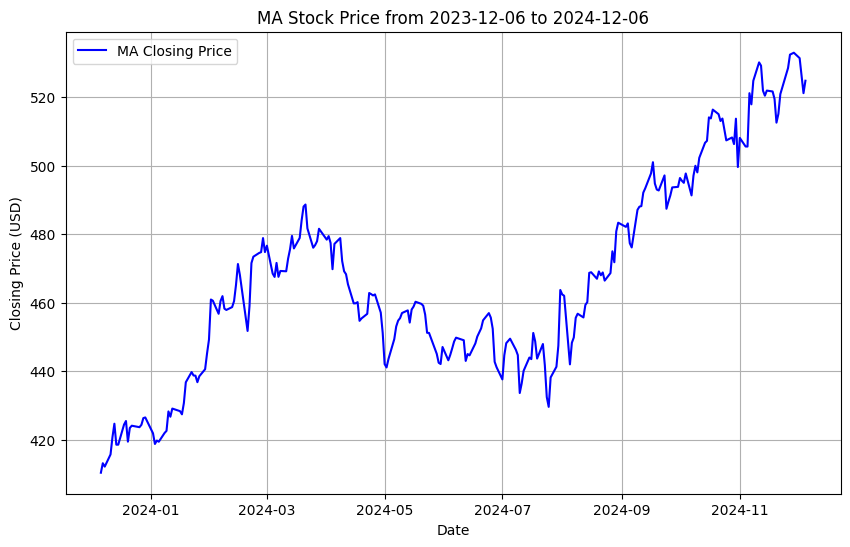

Found tweets file: tweets_MA.csv
Found stock data file: stockData_MA.csv
Stock Data Columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
------------------------------ Processing Tweets -----------------------------
Columns in tweets file: ['created_at', 'text', 'likes']
Sample of tweets data:
                                                 text  likes  \
0  تابعهم ياتبعوكم \nريتويت للدعم \n😍😍😍😍\n@gumter...     64   
1  @EarvLikes I can't believe i killed ma best fr...     31   
2  Pinni:Madyarathiri 2:30ki neeku ma bedroom deg...     28   
3  @Vito82488734 myślę, że w niej samej nie ma je...     27   
4  Ma shqetsun pak xheneten, produksion muti #bbv...     17   

                                              Tweets  Likes  
0  تابعهم ياتبعوكم \nريتويت للدعم \n😍😍😍😍\n@gumter...     64  
1  @EarvLikes I can't believe i killed ma best fr...     31  
2  Pinni:Madyarathiri 2:30ki neeku ma bedroom deg...     28  
3  @Vito82488734 myślę, że w niej 

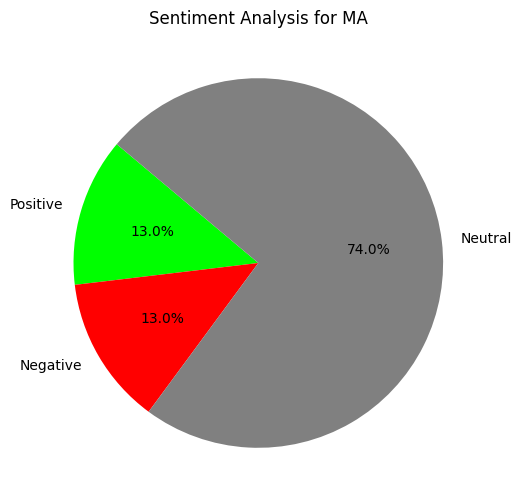

% of Positive Tweets: 13.00%
% of Negative Tweets: 13.00%
% of Neutral Tweets: 74.00%
Completed Sentiment Analysis on Tweets! 


Found sentiment analysis file: sentimentAnalysis_MA.csv
-------- Training and Predicting using Random Forest Regression Model -------


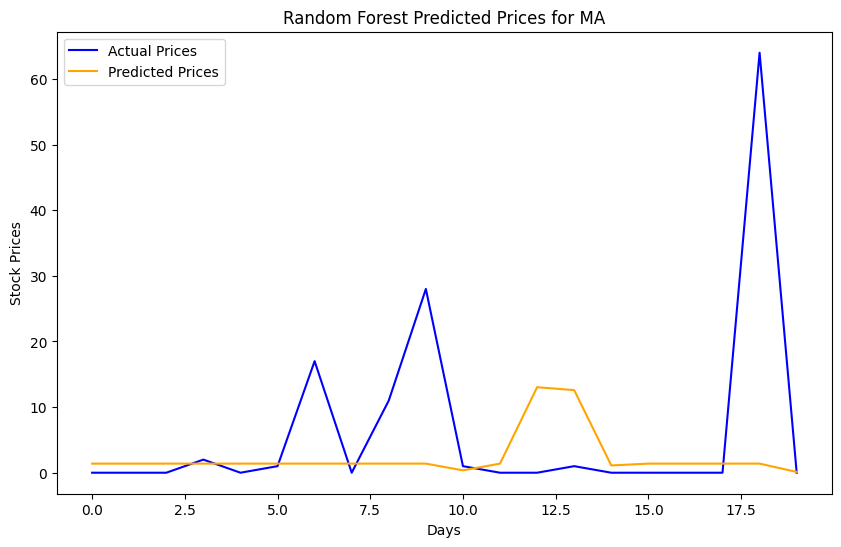


RMSE value for Random Forest Model: 16.26


 

-------- Training and Predicting using Support Vector Regression Model ------------


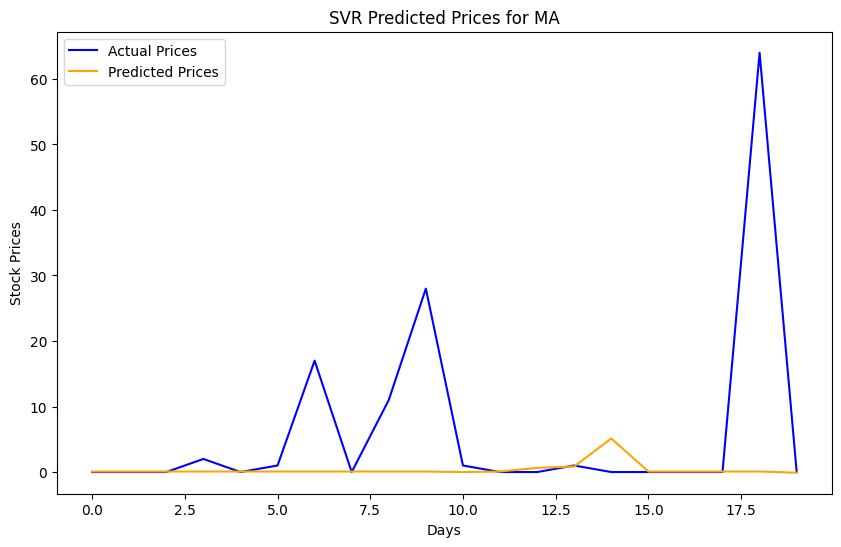


RMSE value for Support Vector Regression Model: 16.28


 



In [51]:
def main():
    # Take input for stock name and date range
    stockname = input("Enter a valid STOCKNAME of the Corporation: ")
    start_date = input("Enter start date (YYYY-MM-DD): ")
    end_date = input("Enter end date (YYYY-MM-DD): ")

    # Get stock data and plot graph
    print(f"Fetching stock data for {stockname} from {start_date} to {end_date}...")
    getStockDetails(stockname, start_date, end_date)

    # Fetch tweets
    print(f"Fetching tweets for {stockname}...")
    fetchTweets(stockname)
    # Check if the tweets file exists
    try:
        df = pd.read_csv(f"tweets_{stockname}.csv")
        print(f"Found tweets file: tweets_{stockname}.csv")
    except FileNotFoundError:
        print(f"File 'tweets_{stockname}.csv' not found. Please run fetchTweets first.")
        return

    # Check if the stock data file exists
    try:
        stock_df = pd.read_csv(f"stockData_{stockname}.csv")
        print(f"Found stock data file: stockData_{stockname}.csv")
        print("Stock Data Columns:", stock_df.columns)
    except FileNotFoundError:
        print(f"File 'stockData_{stockname}.csv' not found. Please ensure stock data is available.")
        return

    # Process Tweets
    print("------------------------------ Processing Tweets -----------------------------")
    processTweets(stockname)
    print("Processed Tweets! \n")

    # Check if processed tweets file is generated
    try:
        processed_df = pd.read_csv(f"processedTweets_{stockname}.csv")
        print(f"Found processed tweets file: processedTweets_{stockname}.csv")
    except FileNotFoundError:
        print(f"File 'processedTweets_{stockname}.csv' not found. Ensure tweets are processed first.")
        return

    # Perform Sentiment Analysis
    print("------------------------------ Performing Sentiment Analysis -----------------------------")
    sentimentAnalysis(stockname)
    print("Completed Sentiment Analysis on Tweets! \n\n")

    # Check if sentiment analysis file is generated
    try:
        sentiment_df = pd.read_csv(f"sentimentAnalysis_{stockname}.csv")
        print(f"Found sentiment analysis file: sentimentAnalysis_{stockname}.csv")
    except FileNotFoundError:
        print(f"File 'sentimentAnalysis_{stockname}.csv' not found. Ensure sentiment analysis is performed first.")
        return

    # Training and Predicting using Random Forest Regression Model
    print("-------- Training and Predicting using Random Forest Regression Model -------")
    RandomForestModel(stockname)
    print("\n \n")

    # Training and Predicting using Support Vector Regression Model
    print("-------- Training and Predicting using Support Vector Regression Model ------------")
    SVRModel(stockname)
    print("\n \n")

# Call the main function
main()
